In [14]:
import os
import glob
import re
import datetime
import glob
from datetime import date, time, timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
from cv2 import VideoCapture, CAP_PROP_FRAME_COUNT, CAP_PROP_FPS, CAP_PROP_POS_FRAMES
import ffmpeg
from imutils.video import FileVideoStream
import time
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import Span, DatetimeTicker, DatetimeTickFormatter
from scipy import stats
from utils import load_diffs, load_slide_changes, load_intervals
from utils import filter_video, plot_slide_diffs, get_signals, evaluate
from utils import sanitize_signals

sns.set()
output_notebook()

Loading BokehJS ...

# Paths

In [181]:
#meeting_id = 160320
#meeting_id = 220120
meeting_id = 170127
#meeting_id = 83512718053

In [182]:
masked = True

In [183]:
video_path = glob.glob(f'zoom_data/{meeting_id}/*.mp4')[0]
print(video_path)
if masked:
    diff_path = f'diff_data/diffs_{meeting_id}_masked_cossim.csv'
else:
    diff_path = f'diff_data/diffs_{meeting_id}_cossim.csv'
sc_labels = f'slide_change_labels/{meeting_id}.csv'
interval_path = 'interval_data/intervals.csv'

zoom_data/170127/GMT20210614-170127_Recording_2350x1322.mp4


# Load FPS, Diffs, Slide Change Labels - then filter diffs by interval

In [184]:
vidcap = VideoCapture(video_path)
fps = vidcap.get(CAP_PROP_FPS)
ddiffs = load_diffs(diff_path, fps)
sldf = load_slide_changes(sc_labels)
idf = load_intervals(interval_path, meeting_id=meeting_id)
ddiffs = filter_video(ddiffs, sldf, idf)

# Get predictions

In [185]:
_, mean_q = get_signals(ddiffs)
percentiles = np.arange(mean_q / 100 - 0.1, 1.0, 0.001)

In [69]:
percentiles

array([0.88844965, 0.88944965, 0.89044965, 0.89144965, 0.89244965,
       0.89344965, 0.89444965, 0.89544965, 0.89644965, 0.89744965,
       0.89844965, 0.89944965, 0.90044965, 0.90144965, 0.90244965,
       0.90344965, 0.90444965, 0.90544965, 0.90644965, 0.90744965,
       0.90844965, 0.90944965, 0.91044965, 0.91144965, 0.91244965,
       0.91344965, 0.91444965, 0.91544965, 0.91644965, 0.91744965,
       0.91844965, 0.91944965, 0.92044965, 0.92144965, 0.92244965,
       0.92344965, 0.92444965, 0.92544965, 0.92644965, 0.92744965,
       0.92844965, 0.92944965, 0.93044965, 0.93144965, 0.93244965,
       0.93344965, 0.93444965, 0.93544965, 0.93644965, 0.93744965,
       0.93844965, 0.93944965, 0.94044965, 0.94144965, 0.94244965,
       0.94344965, 0.94444965, 0.94544965, 0.94644965, 0.94744965,
       0.94844965, 0.94944965, 0.95044965, 0.95144965, 0.95244965,
       0.95344965, 0.95444965, 0.95544965, 0.95644965, 0.95744965,
       0.95844965, 0.95944965, 0.96044965, 0.96144965, 0.96244

In [186]:
threshold_q = None
#signals = evaluate(ddiffs, sldf, threshold_q=threshold_q)[0]
#signals = signals.loc[signals.signal & signals.keep_signal, :]


signals, threshold_q = get_signals(ddiffs, threshold_q=threshold_q)

In [151]:
signals

,elapsed_dt,signal
0,1970-01-01 00:00:01,False
1,1970-01-01 00:00:02,False
2,1970-01-01 00:00:03,False
3,1970-01-01 00:00:04,False
4,1970-01-01 00:00:05,False
...,...,...
6142,1970-01-01 01:58:54,False
6143,1970-01-01 01:58:55,False
6144,1970-01-01 01:58:56,False
6145,1970-01-01 01:58:57,True


In [187]:
signals = sanitize_signals(ddiffs, sldf, signals)
signals = signals.query('signal').reset_index(drop=True)

In [153]:
signals

,elapsed_dt,cos_sim_diff,change_time_dt,signal,plus,minus,signal_to_change_time_dt,max_diff,keep_signal
0,1970-01-01 00:00:57,0.060512,1970-01-01 00:00:57,True,NaT,NaT,1970-01-01 00:00:57,0.060512,True
1,1970-01-01 00:01:29,0.073205,1970-01-01 00:01:29,True,NaT,NaT,1970-01-01 00:01:29,0.073205,True
2,1970-01-01 00:02:07,0.053304,1970-01-01 00:02:07,True,NaT,NaT,1970-01-01 00:02:07,0.053304,True
3,1970-01-01 00:03:35,0.061758,1970-01-01 00:03:35,True,NaT,NaT,1970-01-01 00:03:35,0.061758,True
4,1970-01-01 00:05:36,0.047094,NaT,True,NaT,1970-01-01 00:05:37,1970-01-01 00:05:37,0.047094,True
...,...,...,...,...,...,...,...,...,...
65,1970-01-01 01:53:17,0.039976,1970-01-01 01:53:17,True,NaT,NaT,1970-01-01 01:53:17,0.039976,True
66,1970-01-01 01:54:41,0.038135,1970-01-01 01:54:41,True,NaT,NaT,1970-01-01 01:54:41,0.038135,True
67,1970-01-01 01:55:27,0.048506,NaT,True,NaT,1970-01-01 01:55:28,1970-01-01 01:55:28,0.048506,True
68,1970-01-01 01:57:08,0.050358,1970-01-01 01:57:08,True,NaT,NaT,1970-01-01 01:57:08,0.050358,True


In [188]:
sldf

,change_time,note,change_time_dt
0,0:00:01,Presentation started,1970-01-01 00:00:01
1,0:00:57,NaN,1970-01-01 00:00:57
2,0:1:29,NaN,1970-01-01 00:01:29
3,0:2:07,NaN,1970-01-01 00:02:07
4,0:3:35,NaN,1970-01-01 00:03:35
...,...,...,...
70,1:53:17,NaN,1970-01-01 01:53:17
71,1:54:41,NaN,1970-01-01 01:54:41
72,1:55:28,NaN,1970-01-01 01:55:28
73,1:57:08,NaN,1970-01-01 01:57:08


In [189]:
sldf = sldf.merge(idf, how='cross') \
            .query("change_time_dt >= start_dt and change_time_dt <= stop_dt") \
            .reset_index(drop=True) \
            .assign(elapsed_seconds=lambda x: (x.change_time_dt - x.start_dt).dt.seconds)
sldf

,change_time,note,change_time_dt,meeting_id,start,stop,start_dt,stop_dt,elapsed_seconds
0,0:00:01,Presentation started,1970-01-01 00:00:01,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29,0
1,0:00:57,NaN,1970-01-01 00:00:57,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29,56
2,0:1:29,NaN,1970-01-01 00:01:29,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29,88
3,0:2:07,NaN,1970-01-01 00:02:07,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29,126
4,0:3:35,NaN,1970-01-01 00:03:35,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29,214
...,...,...,...,...,...,...,...,...,...
70,1:53:17,NaN,1970-01-01 01:53:17,170127,1:47:11,1:58:58,1970-01-01 01:47:11,1970-01-01 01:58:58,366
71,1:54:41,NaN,1970-01-01 01:54:41,170127,1:47:11,1:58:58,1970-01-01 01:47:11,1970-01-01 01:58:58,450
72,1:55:28,NaN,1970-01-01 01:55:28,170127,1:47:11,1:58:58,1970-01-01 01:47:11,1970-01-01 01:58:58,497
73,1:57:08,NaN,1970-01-01 01:57:08,170127,1:47:11,1:58:58,1970-01-01 01:47:11,1970-01-01 01:58:58,597


In [190]:
#sldf['slide_count'] = sldf.groupby('start_dt', as_index=False).cumcount() + 1
sldf['slide_count'] = sldf.index + 1
sldf

,change_time,note,change_time_dt,meeting_id,start,stop,start_dt,stop_dt,elapsed_seconds,slide_count
0,0:00:01,Presentation started,1970-01-01 00:00:01,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29,0,1
1,0:00:57,NaN,1970-01-01 00:00:57,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29,56,2
2,0:1:29,NaN,1970-01-01 00:01:29,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29,88,3
3,0:2:07,NaN,1970-01-01 00:02:07,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29,126,4
4,0:3:35,NaN,1970-01-01 00:03:35,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29,214,5
...,...,...,...,...,...,...,...,...,...,...
70,1:53:17,NaN,1970-01-01 01:53:17,170127,1:47:11,1:58:58,1970-01-01 01:47:11,1970-01-01 01:58:58,366,71
71,1:54:41,NaN,1970-01-01 01:54:41,170127,1:47:11,1:58:58,1970-01-01 01:47:11,1970-01-01 01:58:58,450,72
72,1:55:28,NaN,1970-01-01 01:55:28,170127,1:47:11,1:58:58,1970-01-01 01:47:11,1970-01-01 01:58:58,497,73
73,1:57:08,NaN,1970-01-01 01:57:08,170127,1:47:11,1:58:58,1970-01-01 01:47:11,1970-01-01 01:58:58,597,74


In [191]:
sldf['presentation_slide_count'] = sldf.groupby('start_dt', as_index=False).cumcount() + 1
sldf

,change_time,note,change_time_dt,meeting_id,start,stop,start_dt,stop_dt,elapsed_seconds,slide_count,presentation_slide_count
0,0:00:01,Presentation started,1970-01-01 00:00:01,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29,0,1,1
1,0:00:57,NaN,1970-01-01 00:00:57,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29,56,2,2
2,0:1:29,NaN,1970-01-01 00:01:29,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29,88,3,3
3,0:2:07,NaN,1970-01-01 00:02:07,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29,126,4,4
4,0:3:35,NaN,1970-01-01 00:03:35,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29,214,5,5
...,...,...,...,...,...,...,...,...,...,...,...
70,1:53:17,NaN,1970-01-01 01:53:17,170127,1:47:11,1:58:58,1970-01-01 01:47:11,1970-01-01 01:58:58,366,71,8
71,1:54:41,NaN,1970-01-01 01:54:41,170127,1:47:11,1:58:58,1970-01-01 01:47:11,1970-01-01 01:58:58,450,72,9
72,1:55:28,NaN,1970-01-01 01:55:28,170127,1:47:11,1:58:58,1970-01-01 01:47:11,1970-01-01 01:58:58,497,73,10
73,1:57:08,NaN,1970-01-01 01:57:08,170127,1:47:11,1:58:58,1970-01-01 01:47:11,1970-01-01 01:58:58,597,74,11


In [192]:
sldf['seconds_per_slide'] = sldf.elapsed_seconds / sldf.presentation_slide_count
sldf

,change_time,note,change_time_dt,meeting_id,start,stop,start_dt,stop_dt,elapsed_seconds,slide_count,presentation_slide_count,seconds_per_slide
0,0:00:01,Presentation started,1970-01-01 00:00:01,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29,0,1,1,0.000000
1,0:00:57,NaN,1970-01-01 00:00:57,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29,56,2,2,28.000000
2,0:1:29,NaN,1970-01-01 00:01:29,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29,88,3,3,29.333333
3,0:2:07,NaN,1970-01-01 00:02:07,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29,126,4,4,31.500000
4,0:3:35,NaN,1970-01-01 00:03:35,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29,214,5,5,42.800000
...,...,...,...,...,...,...,...,...,...,...,...,...
70,1:53:17,NaN,1970-01-01 01:53:17,170127,1:47:11,1:58:58,1970-01-01 01:47:11,1970-01-01 01:58:58,366,71,8,45.750000
71,1:54:41,NaN,1970-01-01 01:54:41,170127,1:47:11,1:58:58,1970-01-01 01:47:11,1970-01-01 01:58:58,450,72,9,50.000000
72,1:55:28,NaN,1970-01-01 01:55:28,170127,1:47:11,1:58:58,1970-01-01 01:47:11,1970-01-01 01:58:58,497,73,10,49.700000
73,1:57:08,NaN,1970-01-01 01:57:08,170127,1:47:11,1:58:58,1970-01-01 01:47:11,1970-01-01 01:58:58,597,74,11,54.272727


In [195]:
np.where(sldf.elapsed_seconds.diff().isna() | (sldf.elapsed_seconds.diff() < 0), 
        sldf.elapsed_seconds,
        sldf.elapsed_seconds.diff()).astype(int)

array([  0,  56,  32,  38,  88, 122,  79,  74,  91,  77,  16, 104,  50,
        44,  40,  75, 383,  43,  22,  45,  50,  35,  42,  81, 247, 121,
       133,   0,   2,  85, 207,  66,  16,  66,   1,   1,   1,   1,   1,
         1,   1,   1,   5, 430,   0, 134, 204, 136, 360,  49, 265,  16,
         4, 103,  63, 162,  94,  91, 174, 123,   4,  71, 310,   0,   2,
         1,   1,   1,   1, 247, 113,  84,  47, 100, 110])

In [203]:
sldf.groupby(['meeting_id', 'start_dt']).elapsed_seconds.transform(lambda x: np.where(x.diff().isna(), x, x.diff()).astype(int))

array([  0,  56,  32,  38,  88, 122,  79,  74,  91,  77,  16, 104,  50,
        44,  40,  75, 383,  43,  22,  45,  50,  35,  42,  81, 247, 121,
       133,   0,   2,  85, 207,  66,  16,  66,   1,   1,   1,   1,   1,
         1,   1,   1,   5, 430,   0, 134, 204, 136, 360,  49, 265,  16,
         4, 103,  63, 162,  94,  91, 174, 123,   4,  71, 310,   0,   2,
         1,   1,   1,   1, 247, 113,  84,  47, 100, 110])

In [221]:
sldf.groupby(['meeting_id', 'start_dt'], as_index=False)[['start', 'elapsed_seconds']].transform(lambda x: x.size)

,start,elapsed_seconds
0,27,27
1,27,27
2,27,27
3,27,27
4,27,27
...,...,...
70,12,12
71,12,12
72,12,12
73,12,12


In [196]:
np.where(sldf.elapsed_seconds.diff().isna(), 
        sldf.elapsed_seconds,
        sldf.elapsed_seconds.diff()).astype(int)

array([    0,    56,    32,    38,    88,   122,    79,    74,    91,
          77,    16,   104,    50,    44,    40,    75,   383,    43,
          22,    45,    50,    35,    42,    81,   247,   121,   133,
       -2188,     2,    85,   207,    66,    16,    66,     1,     1,
           1,     1,     1,     1,     1,     1,     5,   430,  -885,
         134,   204,   136,   360,    49,   265,    16,     4,   103,
          63,   162,    94,    91,   174,   123,     4,    71,   310,
       -2363,     2,     1,     1,     1,     1,   247,   113,    84,
          47,   100,   110])

In [ ]:
sldf['seconds_on_slide'] = np.where(sldf.elapsed_seconds.diff().isna(), 
                                    sldf.elapsed_seconds,
                                    sldf.elapsed_seconds.diff()).astype(int)
sldf

In [168]:
pred = signals[['elapsed_dt']] \
                 .rename(columns={'elapsed_dt': 'change_time_dt'})

In [169]:
pred

,change_time_dt
0,1970-01-01 00:00:57
1,1970-01-01 00:01:29
2,1970-01-01 00:02:07
3,1970-01-01 00:03:35
4,1970-01-01 00:05:36
...,...
65,1970-01-01 01:53:17
66,1970-01-01 01:54:41
67,1970-01-01 01:55:27
68,1970-01-01 01:57:08


In [170]:
idf

,meeting_id,start,stop,start_dt,stop_dt
0,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29
1,170127,38:13,52:58,1970-01-01 00:38:13,1970-01-01 00:52:58
2,170127,59:53,1:39:16,1970-01-01 00:59:53,1970-01-01 01:39:16
3,170127,1:47:11,1:58:58,1970-01-01 01:47:11,1970-01-01 01:58:58


In [171]:
pred = pred.merge(idf, how='cross') \
            .query("change_time_dt >= start_dt and change_time_dt <= stop_dt") \
            [['change_time_dt', 'start_dt']] \
            .reset_index(drop=True) \
            .assign(elapsed_seconds=lambda x: (x.change_time_dt - x.start_dt).dt.seconds)
pred

,change_time_dt,start_dt,elapsed_seconds
0,1970-01-01 00:00:57,1970-01-01 00:00:01,56
1,1970-01-01 00:01:29,1970-01-01 00:00:01,88
2,1970-01-01 00:02:07,1970-01-01 00:00:01,126
3,1970-01-01 00:03:35,1970-01-01 00:00:01,214
4,1970-01-01 00:05:36,1970-01-01 00:00:01,335
...,...,...,...
65,1970-01-01 01:53:17,1970-01-01 01:47:11,366
66,1970-01-01 01:54:41,1970-01-01 01:47:11,450
67,1970-01-01 01:55:27,1970-01-01 01:47:11,496
68,1970-01-01 01:57:08,1970-01-01 01:47:11,597


In [176]:
pred['slide_count'] = pred.index + 1

In [177]:
pred['presentation_slide_count'] = pred.groupby('start_dt', as_index=False).cumcount() + 1

In [178]:
pred['seconds_per_slide'] = pred.elapsed_seconds / pred.presentation_slide_count

In [179]:
pred['seconds_on_slide'] = np.where(pred.elapsed_seconds.diff().isna(), 
                                    pred.elapsed_seconds,
                                    pred.elapsed_seconds.diff()).astype(int)

In [180]:
pred

,change_time_dt,start_dt,elapsed_seconds,slide_count,presentation_slide_count,seconds_per_slide,seconds_on_slide
0,1970-01-01 00:00:57,1970-01-01 00:00:01,56,1,1,56.000000,56
1,1970-01-01 00:01:29,1970-01-01 00:00:01,88,2,2,44.000000,32
2,1970-01-01 00:02:07,1970-01-01 00:00:01,126,3,3,42.000000,38
3,1970-01-01 00:03:35,1970-01-01 00:00:01,214,4,4,53.500000,88
4,1970-01-01 00:05:36,1970-01-01 00:00:01,335,5,5,67.000000,121
...,...,...,...,...,...,...,...
65,1970-01-01 01:53:17,1970-01-01 01:47:11,366,66,5,73.200000,114
66,1970-01-01 01:54:41,1970-01-01 01:47:11,450,67,6,75.000000,84
67,1970-01-01 01:55:27,1970-01-01 01:47:11,496,68,7,70.857143,46
68,1970-01-01 01:57:08,1970-01-01 01:47:11,597,69,8,74.625000,101


In [90]:
pred.merge(idf, how='cross') \
    .query("change_time_dt >= start_dt and change_time_dt <= stop_dt") \
    [['change_time_dt', 'start_dt']] \
    .reset_index(drop=True) \
    .assign(elapsed_seconds=lambda x: (x.change_time_dt - x.start_dt).dt.seconds) \
    .groupby('start_dt', as_index=False) \
    .transform(lambda x: x)

,change_time_dt,elapsed_seconds
0,1970-01-01 00:00:02,1
1,1970-01-01 00:00:55,54
2,1970-01-01 00:00:57,56
3,1970-01-01 00:01:00,59
4,1970-01-01 00:01:01,60
...,...,...
671,1970-01-01 01:57:23,612
672,1970-01-01 01:58:50,699
673,1970-01-01 01:58:51,700
674,1970-01-01 01:58:54,703


In [77]:
pred['elapsed_seconds'] = (pred.change_time_dt - idf.start_dt[0]).dt.seconds
pred

,change_time_dt,elapsed_seconds
0,1970-01-01 00:00:02,1
1,1970-01-01 00:00:55,54
2,1970-01-01 00:00:57,56
3,1970-01-01 00:01:00,59
4,1970-01-01 00:01:01,60
...,...,...
671,1970-01-01 01:57:23,7042
672,1970-01-01 01:58:50,7129
673,1970-01-01 01:58:51,7130
674,1970-01-01 01:58:54,7133


In [78]:
pred.merge(idf, how='cross')

,change_time_dt,elapsed_seconds,meeting_id,start,stop,start_dt,stop_dt
0,1970-01-01 00:00:02,1,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29
1,1970-01-01 00:00:02,1,170127,38:13,52:58,1970-01-01 00:38:13,1970-01-01 00:52:58
2,1970-01-01 00:00:02,1,170127,59:53,1:39:16,1970-01-01 00:59:53,1970-01-01 01:39:16
3,1970-01-01 00:00:02,1,170127,1:47:11,1:58:58,1970-01-01 01:47:11,1970-01-01 01:58:58
4,1970-01-01 00:00:55,54,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29
...,...,...,...,...,...,...,...
2699,1970-01-01 01:58:54,7133,170127,1:47:11,1:58:58,1970-01-01 01:47:11,1970-01-01 01:58:58
2700,1970-01-01 01:58:57,7136,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29
2701,1970-01-01 01:58:57,7136,170127,38:13,52:58,1970-01-01 00:38:13,1970-01-01 00:52:58
2702,1970-01-01 01:58:57,7136,170127,59:53,1:39:16,1970-01-01 00:59:53,1970-01-01 01:39:16


# Slide count

### True slide count

In [27]:
sldf.shape[0]

18

### Predicted slide count

In [28]:
signals.shape[0]

16

# Seconds per slice (slide pace)

In [31]:
sldf.insert(0, 'meeting_id', 123254)

In [32]:
sldf

,meeting_id,change_time,note,change_time_dt
0,123254,0:1:22,NaN,1970-01-01 00:01:22
1,123254,0:1:56,NaN,1970-01-01 00:01:56
2,123254,0:2:01,NaN,1970-01-01 00:02:01
3,123254,0:3:34,Revisited 2 slides back,1970-01-01 00:03:34
4,123254,0:6:39,Fast forward 2 slides to next slide,1970-01-01 00:06:39
5,123254,0:7:24,Accidental slide change to previous,1970-01-01 00:07:24
6,123254,0:7:25,Correction,1970-01-01 00:07:25
7,123254,0:9:02,NaN,1970-01-01 00:09:02
8,123254,0:10:11,NaN,1970-01-01 00:10:11
9,123254,0:12:47,NaN,1970-01-01 00:12:47


### True slide pace

In [33]:
sldf['elapsed_seconds'] = (sldf.change_time_dt - idf.start_dt[0]).dt.seconds
sldf['slide_count'] = sldf.index + 1
sldf['seconds_per_slide'] = sldf.elapsed_seconds / sldf.slide_count
sldf['signal_type'] = 'true'

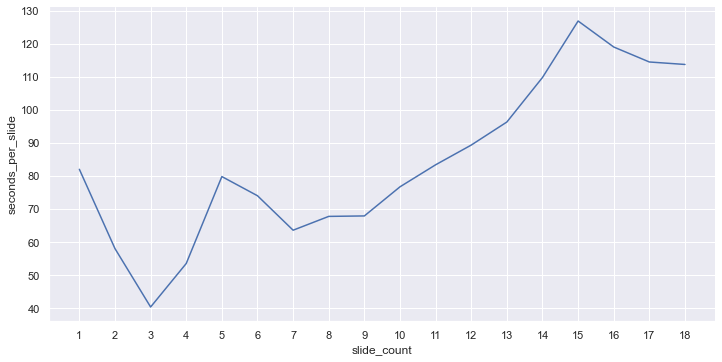

In [144]:
g = sns.relplot(x='slide_count', y='seconds_per_slide', data=sldf, kind='line', aspect=2)
g.set(xticks=sldf.slide_count, yticks=np.arange(np.floor(sldf.seconds_per_slide.min()), sldf.seconds_per_slide.max() + 10, 10))
#for ax in g.axes.flat:
#    ax.axhline(sldf.elapsed_seconds.max() / sldf.shape[0], c='k', linewidth=1)

### Predicted slide pace

In [35]:
pred = signals.reset_index(drop=True)[['signal_to_change_time_dt']].rename(columns={'signal_to_change_time_dt': 'change_time_dt'})

In [36]:
pred['elapsed_seconds'] = (pred.change_time_dt - idf.start_dt[0]).dt.seconds
pred['slide_count'] = pred.index + 1
pred['seconds_per_slide'] = pred.elapsed_seconds / pred.slide_count
pred['signal_type'] = 'predicted'

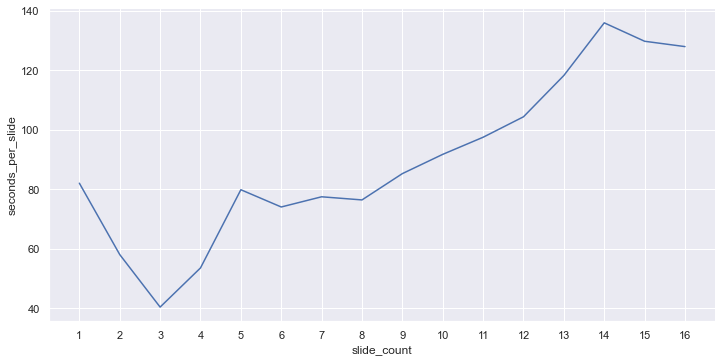

In [37]:
g = sns.relplot(x='slide_count', y='seconds_per_slide', data=pred, kind='line', aspect=2)
g.set(xticks=pred.slide_count)
#for ax in g.axes.flat:
#    ax.axhline(sldf.elapsed_seconds.max() / sldf.shape[0], c='k', linewidth=1)

In [43]:
pred
pred['seconds_on_slide'] = np.where(pred.elapsed_seconds.diff().isna(), pred.elapsed_seconds, pred.elapsed_seconds.diff()).astype(int)
pred

,change_time_dt,elapsed_seconds,slide_count,seconds_per_slide,signal_type,seconds_on_slide
0,1970-01-01 00:01:22,82,1,82.000000,predicted,82
1,1970-01-01 00:01:56,116,2,58.000000,predicted,34
2,1970-01-01 00:02:01,121,3,40.333333,predicted,5
3,1970-01-01 00:03:34,214,4,53.500000,predicted,93
4,1970-01-01 00:06:39,399,5,79.800000,predicted,185
5,1970-01-01 00:07:24,444,6,74.000000,predicted,45
6,1970-01-01 00:09:02,542,7,77.428571,predicted,98
7,1970-01-01 00:10:11,611,8,76.375000,predicted,69
8,1970-01-01 00:12:47,767,9,85.222222,predicted,156
9,1970-01-01 00:15:17,917,10,91.700000,predicted,150


In [44]:
pred.seconds_on_slide.mean()

127.9375

In [40]:
np.where(pred.elapsed_seconds.diff().isna(), pred.elapsed_seconds,pred.elapsed_seconds.diff())

array([ 82.,  34.,   5.,  93., 185.,  45.,  98.,  69., 156., 150., 155.,
       180., 285., 366.,  43., 101.])

### Combined slide pace

In [57]:
true = sldf[['change_time_dt', 'elapsed_seconds', 'slide_count', 'seconds_per_slide', 'signal_type']]

In [64]:
pace_df = pd.concat([true, pred], ignore_index=True)

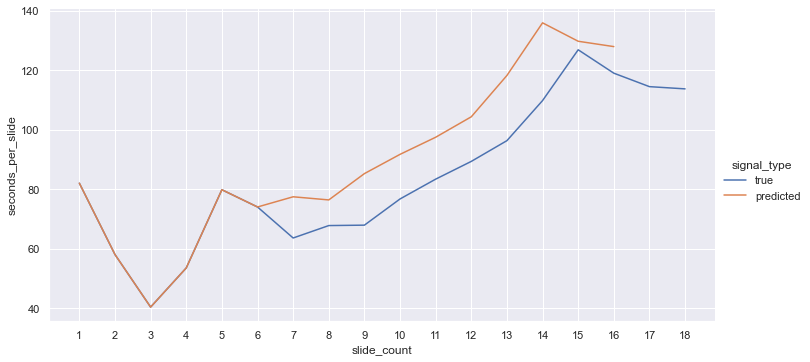

In [65]:
g = sns.relplot(x='slide_count', y='seconds_per_slide', hue='signal_type', data=pace_df, kind='line', aspect=2)
g.set(xticks=pace_df.slide_count.unique())
#for ax in g.axes.flat:
#    ax.axhline(sldf.elapsed_seconds.max() / sldf.shape[0], c='k', linewidth=1)